# Team Assignment


1.   Srinath Mannam (229750)
2.   Meghana Rao (234907)
3.   Govind Shukla (235192)

# import statements

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda

# Change the directory

In [2]:
working_directory = '/content/drive/My Drive/Colab Notebooks/OVGU/Deep_Learning/Second_Assignment'
def colabDrive():
    from google.colab import drive
    drive.mount("/content/drive")

    if os.getcwd() !=  working_directory:
      os.chdir(working_directory)
    print(os.getcwd())

In [3]:
#colabDrive()

# Clears GPU memory

In [4]:
def clearGPUMemory():
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()
    !nvidia-smi

In [5]:
#clearGPUMemory()

# Prepare the data

## Normal MNIST

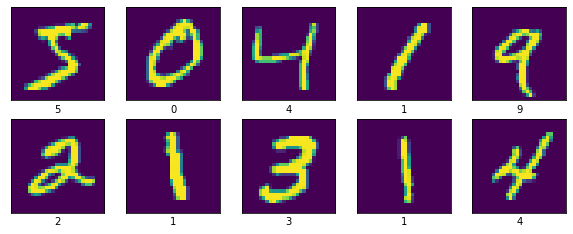

In [35]:
# just data stuff
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()

train_data = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, train_labels.astype(np.int32)))
train_data = train_data.shuffle(buffer_size=60000).batch(128).repeat()

# note: we batch the test data, but do not shuffle/repeat
test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, test_labels.astype(np.int32))).batch(128)

## Fasion MNIST

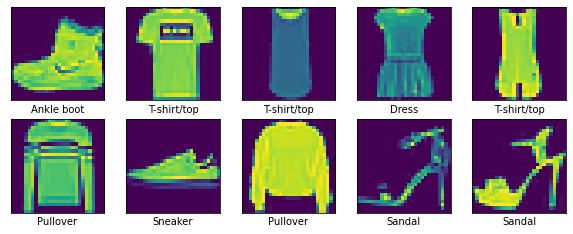

In [36]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_fasion_images, train_fasion_labels), (test_fasion_images, test_fasion_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_fasion_images[i])
    plt.xlabel(class_names[train_fasion_labels[i]])
plt.show()


train_fasion_data = tf.data.Dataset.from_tensor_slices(
    (train_fasion_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, train_fasion_labels.astype(np.int32)))
train_fasion_data = train_fasion_data.shuffle(buffer_size=60000).batch(128).repeat()

# note: we batch the test data, but do not shuffle/repeat
test_fasion_data = tf.data.Dataset.from_tensor_slices(
    (test_fasion_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, test_fasion_labels.astype(np.int32))).batch(128)

# Models Define

## Normal MNIST

In [8]:
def model_normal_MNIST():
  #model params declarations Start

  train_steps = 2500
  input_shape = (28, 28, 1)
  num_classes = 10

  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes)
      ],
      name="Normal_MNIST",
  )

  model.summary()

  optimizer = tf.optimizers.SGD(0.5)  # tune this
  # from_logits = True!! #neverforget
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  #model params declarations End


  #Training Progress Start
  print("Traing Start")
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

  for step, (image_batch, label_batch) in enumerate(train_data):
      if step > train_steps:
          break

      with tf.GradientTape() as tape:
          logits = model(image_batch)
          # loss format is generally: first argument targets, second argument outputs
          loss = loss_fn(label_batch, logits)

      # if you didn't build the model, it is important that you get the variables
      # AFTER the model has been called the first time
      variables = model.trainable_variables
      gradients = tape.gradient(loss, variables)
        
      optimizer.apply_gradients(zip(gradients, variables))
      
      train_acc_metric(label_batch, logits)
      
      if not step % 100:
          # this is different from before. there, we only evaluated accuracy
          # for one batch. Now, we always average over 100 batches
          print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
          train_acc_metric.reset_states()
  print("Traing End")
  #Training Progress End


  #Testing

  # this is very convenient -- before, we usually had code that
  # evaluates the whole test set at once -- this won't work for
  # large datasets/models. With metrics, we can just iterate
  # over the data and the metric takes care of averaging etc.

  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Test acc: {}".format(test_acc_metric.result()))

  #Testing



In [9]:
model_normal_MNIST();

Model: "Normal_MNIST"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)               

## Fashion MNIST

### Fashion MNIST1

In [18]:
def model_fashion_MNIST1():
  #model params declarations Start

  train_steps = 2500
  input_shape = (28, 28, 1)
  num_classes = 10

  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes)
      ],
      name="Fashion_MNIST1",
  )

  model.summary()

  optimizer = tf.optimizers.SGD(0.5)  # tune this
  # from_logits = True!! #neverforget
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  #model params declarations End


  #Training Progress Start
  print("Traing Start")
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

  for step, (image_batch, label_batch) in enumerate(train_fasion_data):
      if step > train_steps:
          break

      with tf.GradientTape() as tape:
          logits = model(image_batch)
          # loss format is generally: first argument targets, second argument outputs
          loss = loss_fn(label_batch, logits)

      # if you didn't build the model, it is important that you get the variables
      # AFTER the model has been called the first time
      variables = model.trainable_variables
      gradients = tape.gradient(loss, variables)
        
      optimizer.apply_gradients(zip(gradients, variables))
      
      train_acc_metric(label_batch, logits)
      
      if not step % 100:
          # this is different from before. there, we only evaluated accuracy
          # for one batch. Now, we always average over 100 batches
          print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
          train_acc_metric.reset_states()
  print("Traing End")
  #Training Progress End


  #Testing

  # this is very convenient -- before, we usually had code that
  # evaluates the whole test set at once -- this won't work for
  # large datasets/models. With metrics, we can just iterate
  # over the data and the metric takes care of averaging etc.

  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_fasion_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Test acc: {}".format(test_acc_metric.result()))

  #Testing



In [19]:
model_fashion_MNIST1();

Model: "Fashion_MNIST1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)             

### Fashion MNIST2

In [29]:
def model_fashion_MNIST2():
  #model params declarations Start

  train_steps = 2500
  input_shape = (28, 28, 1)
  num_classes = 10

  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes)
      ],
      name="Fashion_MNIST2",
  )

  model.summary()

  optimizer = tf.optimizers.Adam(learning_rate=1e-3)  # tune this
  # from_logits = True!! #neverforget
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  #model params declarations End


  #Training Progress Start
  print("Training Start")
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

  for step, (image_batch, label_batch) in enumerate(train_fasion_data):
      if step > train_steps:
          break

      with tf.GradientTape() as tape:
          logits = model(image_batch)
          # loss format is generally: first argument targets, second argument outputs
          loss = loss_fn(label_batch, logits)

      # if you didn't build the model, it is important that you get the variables
      # AFTER the model has been called the first time
      variables = model.trainable_variables
      gradients = tape.gradient(loss, variables)
        
      optimizer.apply_gradients(zip(gradients, variables))
      
      train_acc_metric(label_batch, logits)
      
      if not step % 500:
          # this is different from before. there, we only evaluated accuracy
          # for one batch. Now, we always average over 100 batches
          print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
          train_acc_metric.reset_states()
  print("Training End")
  #Training Progress End


  #Testing

  # this is very convenient -- before, we usually had code that
  # evaluates the whole test set at once -- this won't work for
  # large datasets/models. With metrics, we can just iterate
  # over the data and the metric takes care of averaging etc.

  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_fasion_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Test acc: {}".format(test_acc_metric.result()))

  #Testing



In [30]:
model_fashion_MNIST2();

Model: "Fashion_MNIST2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_36 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_37 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_38 (Batc (None, 13, 13, 128)    

### Fashion MNIST3

In [33]:
def model_fashion_MNIST3():
  #model params declarations Start

  train_steps = 2500
  input_shape = (28, 28, 1)
  num_classes = 10

  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
       
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
       
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes)
      ],
      name="Fashion_MNIST3",
  )

  model.summary()

  optimizer = tf.optimizers.Adam(learning_rate=1e-3)  # tune this
  # from_logits = True!! #neverforget
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  #model params declarations End


  #Training Progress Start
  print("Training Start")
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

  for step, (image_batch, label_batch) in enumerate(train_fasion_data):
      if step > train_steps:
          break

      with tf.GradientTape() as tape:
          logits = model(image_batch)
          # loss format is generally: first argument targets, second argument outputs
          loss = loss_fn(label_batch, logits)

      # if you didn't build the model, it is important that you get the variables
      # AFTER the model has been called the first time
      variables = model.trainable_variables
      gradients = tape.gradient(loss, variables)
        
      optimizer.apply_gradients(zip(gradients, variables))
      
      train_acc_metric(label_batch, logits)
      
      if not step % 500:
          # this is different from before. there, we only evaluated accuracy
          # for one batch. Now, we always average over 100 batches
          print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
          train_acc_metric.reset_states()
  print("Training End")
  #Training Progress End


  #Testing

  # this is very convenient -- before, we usually had code that
  # evaluates the whole test set at once -- this won't work for
  # large datasets/models. With metrics, we can just iterate
  # over the data and the metric takes care of averaging etc.

  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_fasion_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Test acc: {}".format(test_acc_metric.result()))

  #Testing



In [34]:
model_fashion_MNIST3();

Model: "Fashion_MNIST3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_48 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_49 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_12 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 14, 14, 64)     

# CIFAR Dataset

#References


1.   https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
2.   https://ovgu-ailab.github.io/idl2021/assignments/3/mlp_keras.ipynb
3.   https://keras.io/examples/vision/mnist_convnet/
4.   https://medium.com/@mjbhobe/classifying-fashion-with-a-keras-cnn-achieving-94-accuracy-part-1-1ffcb7e5f61a

